In [39]:
import numpy as np
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

# Load Data

In [2]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.fashion_mnist.load_data()
img_shape = np.concatenate((test_x.shape[1:], [1]))
number_of_classes = len(np.unique(test_y))

train_x = train_x / 255.0
test_x = test_x / 255.0

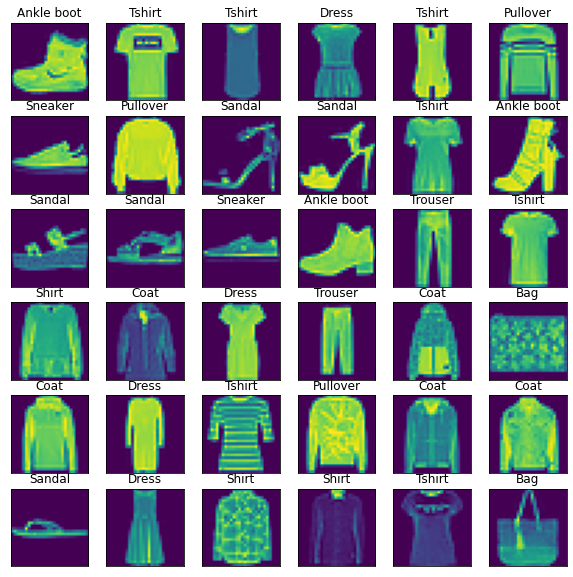

In [3]:
class_names= ['Tshirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6,6, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_x[i].reshape((28,28)))
    label_index= int(train_y[i])
    plt.title(class_names[label_index])
plt.show()

# Resnet 50

In [4]:
def res_identity_layer(X, filters):
  X_shortcut = X
  filter1, filter2 = filters
   
  X = tf.keras.layers.Conv2D(filter1, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
  X = tf.keras.layers.BatchNormalization()(X)
  X = tf.keras.layers.Activation(tf.keras.activations.relu)(X)

  
  X = tf.keras.layers.Conv2D(filter1, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
  X = tf.keras.layers.BatchNormalization()(X)
  X = tf.keras.layers.Activation(tf.keras.activations.relu)(X)

  
  X = tf.keras.layers.Conv2D(filter2, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
  X = tf.keras.layers.BatchNormalization()(X)

  # add the input 
  X = tf.keras.layers.Add()([X, X_shortcut])
  X = tf.keras.layers.Activation(tf.keras.activations.relu)(X)

  return X

In [5]:
def res_convlution_layer(X, s, filters):
  X_shortcut = X
  filter1, filter2 = filters

  X = tf.keras.layers.Conv2D(filter1, kernel_size=(1, 1), strides=(s, s), padding='valid')(X)
  X = tf.keras.layers.BatchNormalization()(X)
  X = tf.keras.layers.Activation(tf.keras.activations.relu)(X)

  X = tf.keras.layers.Conv2D(filter1, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
  X = tf.keras.layers.BatchNormalization()(X)
  X = tf.keras.layers.Activation(tf.keras.activations.relu)(X)

  X = tf.keras.layers.Conv2D(filter2, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
  X = tf.keras.layers.BatchNormalization()(X)

  X_shortcut = tf.keras.layers.Conv2D(filter2, kernel_size=(1, 1), strides=(s, s), padding='valid')(X_shortcut)
  X_shortcut = tf.keras.layers.BatchNormalization()(X_shortcut)

  X = tf.keras.layers.Add()([X, X_shortcut])
  X = tf.keras.layers.Activation(tf.keras.activations.relu)(X)

  return X

In [6]:
def build_resnet50(input_shape, classes_num):
  input_im = tf.keras.layers.Input(shape=input_shape)
  x = tf.keras.layers.ZeroPadding2D(padding=(3, 3))(input_im)

  # 1st stage
  x = tf.keras.layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)
  x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

  #2nd stage 
  x = res_convlution_layer(x, s=1, filters=(64, 256))
  x = res_identity_layer(x, filters=(64, 256))
  x = res_identity_layer(x, filters=(64, 256))

  # 3rd stage
  x = res_convlution_layer(x, s=2, filters=(128, 512))
  x = res_identity_layer(x, filters=(128, 512))
  x = res_identity_layer(x, filters=(128, 512))
  x = res_identity_layer(x, filters=(128, 512))

  # 4th stage
  x = res_convlution_layer(x, s=2, filters=(256, 1024))
  x = res_identity_layer(x, filters=(256, 1024))
  x = res_identity_layer(x, filters=(256, 1024))
  x = res_identity_layer(x, filters=(256, 1024))
  x = res_identity_layer(x, filters=(256, 1024))
  x = res_identity_layer(x, filters=(256, 1024))

  # 5th stage
  x = res_convlution_layer(x, s=2, filters=(512, 2048))
  x = res_identity_layer(x, filters=(512, 2048))
  x = res_identity_layer(x, filters=(512, 2048))

  # average pooling and dense connection
  x = tf.keras.layers.AveragePooling2D((2, 2), padding='same')(x)

  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(classes_num, activation='softmax', kernel_initializer='he_normal')(x)

  model = tf.keras.Model(inputs=input_im, outputs=x, name='Resnet50')

  return model

# Siamese Model

In [7]:
def build_siamese_model(input_shape, feature_model):
  first_img_input = tf.keras.layers.Input(shape =img_shape, name = 'first_img_input')
  second_img_input = tf.keras.layers.Input(shape =img_shape, name = 'second_img_input')
  first_img_features = feature_model(first_img_input)
  second_img_features = feature_model(second_img_input)
  combined_features = tf.keras.layers.concatenate([first_img_features, second_img_features], name='merge_features')
  combined_features = tf.keras.layers.Dense(16, activation = 'linear')(combined_features)
  combined_features = tf.keras.layers.BatchNormalization()(combined_features)
  combined_features = tf.keras.layers.Activation('relu')(combined_features)
  combined_features = tf.keras.layers.Dense(4, activation = 'linear')(combined_features)
  combined_features = tf.keras.layers.BatchNormalization()(combined_features)
  combined_features = tf.keras.layers.Activation('relu')(combined_features)
  combined_features = tf.keras.layers.Dense(1, activation = 'sigmoid')(combined_features)
  model = tf.keras.Model(inputs = [first_img_input, second_img_input], outputs=[combined_features], name = 'Siamese_model')
  return model

# Data Preprocessing

In [8]:
def gen_random_batch(in_groups, batch_halfsize=8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size=batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

In [9]:
train_x,validate_x,train_y,validate_y = train_test_split(train_x,train_y,test_size = 0.2)
train_x.shape, validate_x.shape,train_y.shape,validate_y.shape

((48000, 28, 28), (12000, 28, 28), (48000,), (12000,))

In [10]:
train_groups = [train_x[np.where(train_y==i)[0]] for i in np.unique(train_y)]
test_groups = [test_x[np.where(test_y==i)[0]] for i in np.unique(test_y)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [4785, 4843, 4746, 4820, 4787, 4787, 4826, 4817, 4816, 4773]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


# Training

In [29]:
resnet_model = build_resnet50(img_shape, number_of_classes)
model = build_siamese_model(img_shape, resnet_model)
opt = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'mae'])

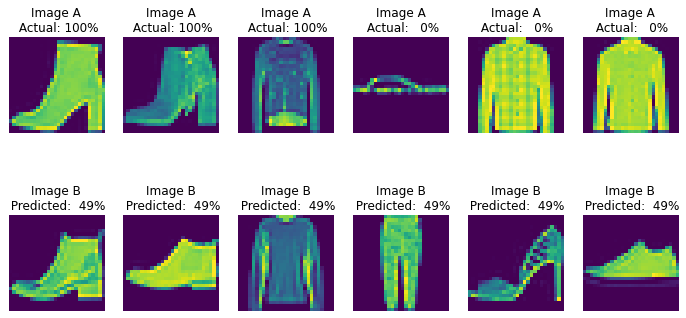

In [30]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim,
        m_axs.T):
        ax1.imshow(c_a)
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b)
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig
    # a completely untrained model
_ = show_model_output()

In [31]:
def siam_gen(in_groups, batch_size=128):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim

valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)

save_model = tf.keras.callbacks.ModelCheckpoint(
    "/content/model",
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.0001, min_delta=0.005)

loss_history = model.fit(
    siam_gen(train_groups),
    steps_per_epoch=500,
    validation_data=([valid_a, valid_b], valid_sim),
    epochs=10,
    verbose=True,
    callbacks=[reduce_lr]
)

Epoch 1/10
500/500 [==============================] - 87s 157ms/step - loss: 0.5614 - accuracy: 0.7103 - mae: 0.3868 - val_loss: 0.5021 - val_accuracy: 0.7520 - val_mae: 0.3444 - lr: 0.0100
Epoch 2/10
500/500 [==============================] - 76s 152ms/step - loss: 0.4932 - accuracy: 0.7526 - mae: 0.3365 - val_loss: 0.4465 - val_accuracy: 0.7866 - val_mae: 0.3044 - lr: 0.0100
Epoch 3/10
500/500 [==============================] - 76s 151ms/step - loss: 0.4645 - accuracy: 0.7686 - mae: 0.3136 - val_loss: 0.4147 - val_accuracy: 0.8242 - val_mae: 0.2981 - lr: 0.0100
Epoch 4/10
500/500 [==============================] - 77s 153ms/step - loss: 0.3770 - accuracy: 0.8355 - mae: 0.2441 - val_loss: 0.3529 - val_accuracy: 0.8535 - val_mae: 0.2165 - lr: 0.0100
Epoch 5/10
500/500 [==============================] - 79s 157ms/step - loss: 0.3419 - accuracy: 0.8523 - mae: 0.2178 - val_loss: 0.3253 - val_accuracy: 0.8560 - val_mae: 0.2081 - lr: 0.0100
Epoch 6/10
500/500 [==============================

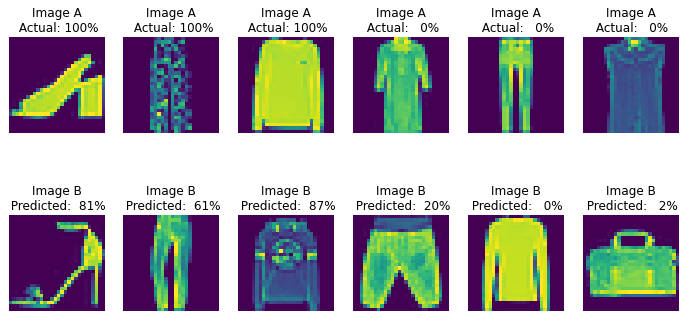

In [32]:
_ = show_model_output()

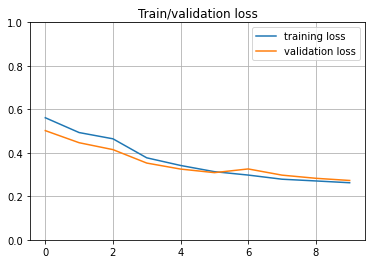

In [33]:
def plot_history(history):
    plt.title('Train/validation loss')
    plt.plot(history.history['loss'], label = 'training loss')
    plt.plot(history.history['val_loss'], label = 'validation loss')
    plt.grid()
    plt.legend()
    plt.ylim(0,1)
    plt.show()

plot_history(loss_history)

# Test model

In [34]:
def find_similar(image, images, count=3, threshold=50):
    pv_a, pv_b = np.reshape([image]*len(images), (len(images), 28,28)), np.reshape(images, (len(images), 28,28))
    pred_sim = model.predict([pv_a, pv_b]).ravel()
    indxs = np.argsort(pred_sim)[::-1][:count]
    
    fig, m_axs = plt.subplots(2, count, figsize = (12, 6))
    i = 0
    for c_a, (ax1, ax2) in zip(pv_a[:count], m_axs.T):
        
        ax1.imshow(c_a)
        ax1.set_title('Input image\n')
        ax1.axis('off')
        ax2.imshow(pv_b[indxs[i]])
        ax2.set_title('Similar\n Predicted: %3.0f%%' % (100*pred_sim[indxs[i]]))
        ax2.axis('off')
        i += 1

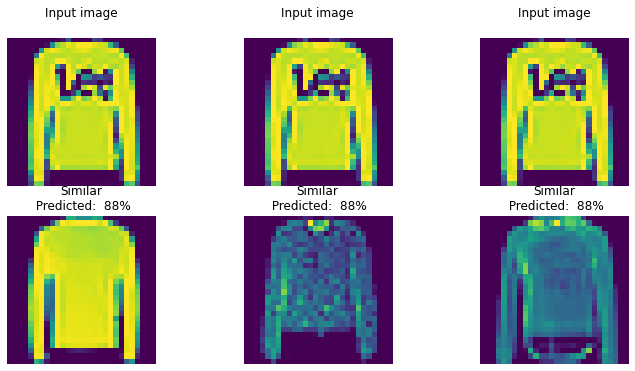

In [37]:
find_similar(test_x[1], images=test_x[1:100])

# t-SNE

In [38]:
x_test_features = resnet_model.predict(test_x, verbose = True,batch_size=128)

79/79 [==============================] - 2s 18ms/step


In [40]:
tsne_obj = TSNE(n_components=2,
                init='pca',
                random_state=101,
                method='barnes_hut',
                n_iter=500,
                verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.027s...
[t-SNE] Computed neighbors for 10000 samples in 0.410s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 1.908s


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Iteration 50: error = 73.9328384, gradient norm = 0.0307092 (50 iterations in 5.037s)
[t-SNE] Iteration 100: error = 67.9565277, gradient norm = 0.0037492 (50 iterations in 3.147s)
[t-SNE] Iteration 150: error = 65.6284790, gradient norm = 0.0023763 (50 iterations in 2.967s)
[t-SNE] Iteration 200: error = 64.2789001, gradient norm = 0.0019080 (50 iterations in 2.979s)
[t-SNE] Iteration 250: error = 63.3765488, gradient norm = 0.0015680 (50 iterations in 2.988s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.376549
[t-SNE] Iteration 300: error = 2.0394239, gradient norm = 0.0012315 (50 iterations in 3.097s)
[t-SNE] Iteration 350: error = 1.5199292, gradient norm = 0.0005995 (50 iterations in 3.088s)
[t-SNE] Iteration 400: error = 1.2489957, gradient norm = 0.0003623 (50 iterations in 3.062s)
[t-SNE] Iteration 450: error = 1.0906543, gradient norm = 0.0002473 (50 iterations in 3.152s)
[t-SNE] Iteration 500: error = 0.9875910, gradient norm = 0.0001836 (50 

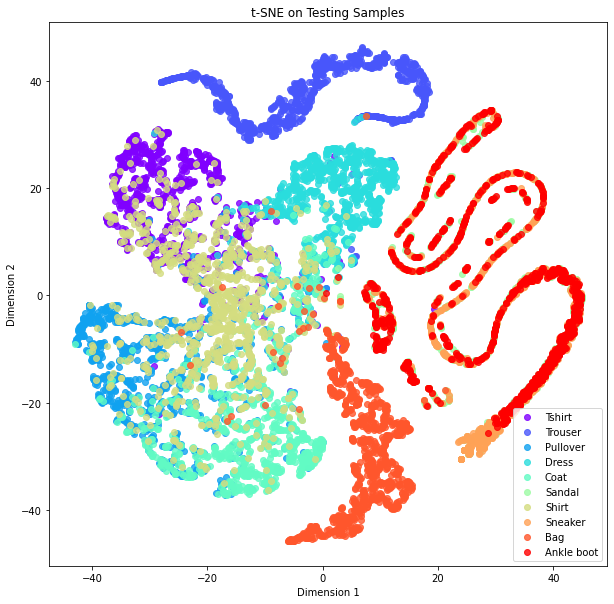

In [42]:
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, class_names)):
    plt.scatter(tsne_features[np.where(test_y == c_group), 0],
    tsne_features[np.where(test_y == c_group), 1],
    marker='o',
    color=c_color,
    linewidth='1',
    alpha=0.8,
    label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)